In [140]:
import scipy as sp
import numpy as np
import pandas as pd
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime
import re
import timeit


pd.options.display.max_rows = 4000

In [79]:
# Pulling data from ANRGUSC github
df = pd.read_csv('https://raw.githubusercontent.com/ANRGUSC/covid19_risk_estimation/master/data/Covid-19-R.csv')



# Pulling data from ANRGUSC github
df = pd.read_csv('https://raw.githubusercontent.com/ANRGUSC/covid19_risk_estimation/master/data/Covid-19-R.csv')
df_infection = pd.read_csv('https://raw.githubusercontent.com/ANRGUSC/covid19_risk_estimation/master/data/Covid-19.csv')
df_county_names = pd.read_csv('county_storage.csv')

# Converting String into Datetime data type
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])  
df_infection['Time Stamp'] = pd.to_datetime(df_infection['Time Stamp'])  

# Dropping 'Latitude' and 'Longitude' columns from df_infection
df_infection = df_infection.drop(['Latitude', 'Longitude'], axis=1)

# Combining two tables together
df = pd.merge(df, df_infection,  how='left', left_on=['Time Stamp','Region'], right_on = ['Time Stamp','Region'])


In [136]:

# Converting String into Datetime data type
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])

# Dropping Any Data with no Risk Score
df=df[df['Risk-Score']!=-1]

# renaming the first column to index
df=df.rename(columns={"Unnamed: 0": "index"})


In [167]:
# Defining LA county and LA city 


unique_regions = df_county_names['location'].unique()


pattern="^LOS ANGELES - "

extr_region=df_county_names['location'].str.contains(pattern)
los_angeles_region = df_county_names[extr_region]['location']


los_angeles_region=los_angeles_region.str.replace('LOS ANGELES - ','').unique()

los_angeles_region



        
        

array(['ADAMS-NORMANDIE', 'ALSACE', 'ANGELINO HEIGHTS', 'ARLETA',
       'ATWATER VILLAGE', 'BALDWIN HILLS', 'BEL AIR', 'BEVERLY CREST',
       'BEVERLYWOOD', 'BOYLE HEIGHTS', 'BRENTWOOD', 'BROOKSIDE',
       'CADILLAC-CORNING', 'CANOGA PARK', 'CARTHAY', 'CENTRAL',
       'CENTURY CITY', 'CENTURY PALMS/COVE', 'CHATSWORTH',
       'CHEVIOT HILLS', 'CHINATOWN', 'CLOVERDALE/COCHRAN',
       'COUNTRY CLUB PARK', 'CRENSHAW DISTRICT', 'CRESTVIEW', 'DEL REY',
       'DOWNTOWN', 'EAGLE ROCK', 'EAST HOLLYWOOD', 'ECHO PARK',
       'EL SERENO', 'ELYSIAN PARK', 'ELYSIAN VALLEY', 'ENCINO',
       'EXPOSITION', 'EXPOSITION PARK', 'FAIRCREST HEIGHTS',
       'FIGUEROA PARK SQUARE', 'FLORENCE-FIRESTONE', 'GLASSELL PARK',
       'GRAMERCY PLACE', 'GRANADA HILLS', 'GREEN MEADOWS', 'HANCOCK PARK',
       'HARBOR CITY', 'HARBOR GATEWAY', 'HARBOR PINES', 'HARVARD HEIGHTS',
       'HARVARD PARK', 'HIGHLAND PARK', 'HISTORIC FILIPINOTOWN',
       'HOLLYWOOD', 'HOLLYWOOD HILLS', 'HYDE PARK', 'JEFFERSON PARK',

In [82]:
regions = df['Region'].unique()
df_new=df.copy()

df_new_cases = pd.DataFrame()

for region in regions:
    df_region = df_new[df_new['Region']==region].sort_values('Time Stamp')
    for date in df_region['Time Stamp']:
        day_before = date - dt.timedelta(days=1)
        df_on_day = df_region[df_region['Time Stamp']==date]
        
        cases_on_day = df_on_day['Number of cases']
        cases_day_before = df_region[df_region['Time Stamp']==day_before]['Number of cases']
        
        if not cases_day_before.empty:
            new_cases = cases_on_day.iloc[0] - cases_day_before.iloc[0]
        
        
            new_row = {'index':df_on_day['index'].iloc[0], 'New Cases':new_cases}
        #append row to the dataframe
            df_new_cases = df_new_cases.append(new_row, ignore_index=True)
        

        

       

    
df_new_cases

,New Cases,index
0,-1.0,30.0
1,0.0,72.0
2,1.0,117.0
3,1.0,186.0
4,0.0,268.0
...,...,...
34340,10.0,32028.0
34341,11.0,32268.0
34342,10.0,32508.0
34343,23.0,32748.0


In [83]:
# Adding new cases data into df
df = pd.merge(left=df, right=df_new_cases, how='left', on='index')

In [123]:
# Finding out what different levels mean

df_0 = df[df['Risk-Level']==0]['Risk-Score']
df_1 = df[df['Risk-Level']==1]['Risk-Score']
df_2 = df[df['Risk-Level']==2]['Risk-Score']
df_3 = df[df['Risk-Level']==3]['Risk-Score']

print("level 0 is between %f and %f" %(min(df_0),max(df_0)))
print("level 1 is between %f and %f" %(min(df_1),max(df_1)))
print("level 2 is between %f and %f" %(min(df_2),max(df_2)))
print("level 3 is between %f and %f" %(min(df_3),max(df_3)))

level 0 is between 0.000000 and 0.099892
level 1 is between 0.100022 and 0.999895
level 2 is between 1.000413 and 1.999766
level 3 is between 2.000270 and 669.857935


In [168]:
# start_time = timeit.default_timer()


# This function calculates trend of the Risk-Score overtime.
# Input:  area:               this can be either 'all' or specific name of the region
#         length1, length2:   these parameters define the windows of the rolling/moving average
# Output: df_updated:         this new dataframe contains new rolling averages, and risk-score difference in addition to original data

def calc_risk_trend(area, length1, length2):
    df_recent_1= pd.DataFrame()
    df_recent_2= pd.DataFrame()
    df_rolling_1= pd.DataFrame()
    df_rolling_2= pd.DataFrame()
    df_rolling_cases = pd.DataFrame()
    rs_diff_3 = []
    rs_diff_7 = []
    
    if area == 'LA County': # if 'all' is given, iterate through all regions in the data
        regions = 'LA County'
        df_mean = df.copy()
        df_mean = df_mean.groupby(["Time Stamp"]).mean()
        df_mean=df_mean.drop(['Number of cases','New Cases'], axis=1)adams
        df_sum = df_sum.groupby(["Time Stamp"]).sum()
        df_sum = df_sum[['Number of cases','New Cases']]
        df_new=df_sum.merge(df_mean, left_index=True, right_index=True, how='left')
        df_new['Region']='LA County'
        df_new['Time Stamp']=df_new.index
        recent_date = max(df_new['Time Stamp'])
        length1_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length1)
        length2_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length2)
        
        df_1_before = df_new[df_new['Time Stamp'] == length1_bef]
        df_2_before = df_new[df_new['Time Stamp'] == length2_bef]
        df_recent = df_new[df_new['Time Stamp']==recent_date]

        string1= "RS_change_{}".format(length1)
        string2= "RS_change_{}".format(length2)

        # calculating the Risk-Score difference between most current data to the past data
        if not df_1_before['Risk-Score'].empty:
            df_recent[string1] = df_recent['Risk-Score'].iloc[0]-df_1_before['Risk-Score'].iloc[0]
        else:
            df_recent[string1] = df_recent['Risk-Score'].iloc[0]

        if not df_2_before['Risk-Score'].empty:
            df_recent[string2] = df_recent['Risk-Score'].iloc[0]-df_2_before['Risk-Score'].iloc[0]
        else:
            df_recent[string2] = df_recent['Risk-Score'].iloc[0]

        df_recent_1 = df_recent_1.append(df_recent[['index',string1]]) # adding the differences to a list
        df_recent_2 = df_recent_2.append(df_recent[['index',string2]])



        # calculating rolling averages
        rolling_rs_1 = df_new['Risk-Score'].rolling(length1, min_periods=1).mean()
        rolling_rs_2 = df_new['Risk-Score'].rolling(length2, min_periods=1).mean()
        rolling_cases = df_new['New Cases'].rolling(length1, min_periods=1).mean()
#         rolling_rs_1 = df_region['Risk-Score'].ewm(span=length1, adjust=False).mean() #this is for exponential rolling average
#         rolling_rs_2 = df_region['Risk-Score'].ewm(span=length2, adjust=False).mean()


        df_rolling_1 = df_rolling_1.append(rolling_rs_1)
        df_rolling_2 = df_rolling_2.append(rolling_rs_2)
        df_rolling_cases = df_rolling_cases.append(rolling_cases)
        
        df_rolling_1_sum = df_rolling_1.sum(skipna = True, axis=0)
        df_rolling_2_sum = df_rolling_2.sum(skipna = True, axis=0)
        df_rolling_cases_sum = df_rolling_cases.sum(skipna = True, axis=0)

        rolling_1 = pd.DataFrame()
        rolling_2 = pd.DataFrame()
        rolling_c = pd.DataFrame()

        string3 = "Rolling Average {} Days".format(length1)
        string4 = "Rolling Average {} Days".format(length2)

        rolling_1[string3]=df_rolling_1_sum
        rolling_2[string4]=df_rolling_2_sum
        rolling_c['New Cases Rolling Avg']=df_rolling_cases_sum
        
        df_updated = df_new.merge(rolling_1, left_index=True, right_index=True, how='left')
        df_updated = df_updated.merge(rolling_2, left_index=True, right_index=True, how='left')
        df_updated = df_updated.merge(rolling_c, left_index=True, right_index=True, how='left')

        
    else:
        regions = [area]
        df_new = df[df['Region']==area]


        for region in regions:
            df_region = df_new[df_new['Region']==region].sort_values('Time Stamp')


            # defining specific dates that we are going to pull data from
            recent_date = max(df_region['Time Stamp'])
            length1_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length1)
            length2_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length2)

            # pulling data matching dates defined
            df_1_before = df_region[df_region['Time Stamp'] == length1_bef]
            df_2_before = df_region[df_region['Time Stamp'] == length2_bef]
            df_recent = df_region[df_region['Time Stamp']==recent_date]




            string1= "RS_change_{}".format(length1)
            string2= "RS_change_{}".format(length2)

            # calculating the Risk-Score difference between most current data to the past data
            if not df_1_before['Risk-Score'].empty:
                df_recent[string1] = df_recent['Risk-Score'].iloc[0]-df_1_before['Risk-Score'].iloc[0]
            else:
                df_recent[string1] = df_recent['Risk-Score'].iloc[0]

            if not df_2_before['Risk-Score'].empty:
                df_recent[string2] = df_recent['Risk-Score'].iloc[0]-df_2_before['Risk-Score'].iloc[0]
            else:
                df_recent[string2] = df_recent['Risk-Score'].iloc[0]

            df_recent_1 = df_recent_1.append(df_recent[['index',string1]]) # adding the differences to a list
            df_recent_2 = df_recent_2.append(df_recent[['index',string2]])



            # calculating rolling averages
            rolling_rs_1 = df_region['Risk-Score'].rolling(length1, min_periods=1).mean()
            rolling_rs_2 = df_region['Risk-Score'].rolling(length2, min_periods=1).mean()
            rolling_cases = df_region['New Cases'].rolling(length1, min_periods=1).mean()
    #         rolling_rs_1 = df_region['Risk-Score'].ewm(span=length1, adjust=False).mean() #this is for exponential rolling average
    #         rolling_rs_2 = df_region['Risk-Score'].ewm(span=length2, adjust=False).mean()


            df_rolling_1 = df_rolling_1.append(rolling_rs_1)
            df_rolling_2 = df_rolling_2.append(rolling_rs_2)
            df_rolling_cases = df_rolling_cases.append(rolling_cases)




    #     df_updated = pd.merge(left=df_new, right=df_recent_1, how='left', on='index')
        df_updated = df_new.merge(df_recent_1, left_index=True, right_index=True, how='left')
        df_updated = df_updated.merge(df_recent_2, left_index=True, right_index=True, how='left')
    #     df_updated = pd.merge(left=df_updated, right=df_recent_2, how='left', on='index')

        df_rolling_1_sum = df_rolling_1.sum(skipna = True, axis=0)
        df_rolling_2_sum = df_rolling_2.sum(skipna = True, axis=0)
        df_rolling_cases_sum = df_rolling_cases.sum(skipna = True, axis=0)

        rolling_1 = pd.DataFrame()
        rolling_2 = pd.DataFrame()
        rolling_c = pd.DataFrame()

        string3 = "Rolling Average {} Days".format(length1)
        string4 = "Rolling Average {} Days".format(length2)

        rolling_1[string3]=df_rolling_1_sum
        rolling_2[string4]=df_rolling_2_sum
        rolling_c['New Cases Rolling Avg']=df_rolling_cases_sum

        df_updated = df_updated.merge(rolling_1, left_index=True, right_index=True, how='left')
        df_updated = df_updated.merge(rolling_2, left_index=True, right_index=True, how='left')
        df_updated = df_updated.merge(rolling_c, left_index=True, right_index=True, how='left')

        df_updated = df_updated.sort_values('Time Stamp')
    
    
    
    return df_updated

# elapsed = timeit.default_timer() - start_time
# print(elapsed)


SyntaxError: invalid syntax (<ipython-input-168-7415daefbf17>, line 22)

In [170]:

# this function uses calc_risk_trend function to calculate the rolling average and creates a time-series plot
# thsi function only works when a specific region is given

def plot_rs(city_name,length1,length2):
    df_final = calc_risk_trend(city_name, length1, length2)
    df_a = df[df['Region']==city_name].sort_values('Time Stamp')
#     plt.figure(figsize=(20,10)) 




#     string3 = "Rolling Average {} Days".format(length1)
#     string4 = "Rolling Average {} Days".format(length2)
    
    
#     plt.plot('Time Stamp','Risk-Score',marker='o', data =df_a, color='black')
#     plt.plot('Time Stamp',string3, marker='o', data =df_final, color='red')
#     plt.plot('Time Stamp',string4, marker='o', data =df_final, color='blue')
#     plt.plot('Time Stamp',string4, marker='o', data =df_final, color='blue')




#     plt.legend()
#     plt.xticks(rotation=90)
#     plt.xlabel('Date')
#     plt.ylabel('Risk Score')
#     plt.title('Risk Score of ' + city_name)
    
    
#     y_max=max(df_final['Risk-Score'])
#     y_max=y_max+y_max/10

#     plt.axhspan(0,1, color='green', alpha=0.1)
#     plt.axhspan(1,2, color='yellow', alpha=0.1)
#     plt.axhspan(2,y_max+10, color='red', alpha=0.1)
#     plt.ylim(0,y_max)
#     plt.grid()

#     fig, ax_left = plt.subplots(figsize=(20,10))
    fig = plt.figure(figsize=(20,10))
    ax_left = fig.add_subplot()
    ax_right = ax_left.twinx()
    
    string3 = "Rolling Average {} Days".format(length1)
    string4 = "Rolling Average {} Days".format(length2)
    
    lns1 = ax_left.plot('Time Stamp','Risk-Score',marker='o', data =df_final, color='black')
    lns2 = ax_left.plot('Time Stamp',string3, marker='o', data =df_final, color='red')
    lns3 = ax_right.plot('Time Stamp','New Cases', marker='o', data =df_final, color='green')
    lns4 = ax_right.plot('Time Stamp','New Cases Rolling Avg', marker='o', data =df_final, color='blue')
#     ax_left.legend(loc='best')
    
    lns = lns1+lns2+lns3+lns4
    labs = [l.get_label() for l in lns]
    ax_left.legend(lns, labs, loc=2)

    ax_left.grid()
    ax_left.set_xlabel("Date",fontsize=15)
    ax_left.set_ylabel("Risk Score",fontsize=15)
    ax_right.set_ylabel("Number of New Cases",fontsize=15)
    
    df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])

    
    y_max=max(df_final['Risk-Score'])
    y_max=y_max+y_max/10
    y_max_right = max(df_new_case_drop['New Cases'])
    y_max_right = y_max_right + y_max_right/10
    
    ax_left.axhspan(0.1,1, color='green', alpha=0.1)
    ax_left.axhspan(1,2, color='yellow', alpha=0.1)
    ax_left.axhspan(2,y_max+10, color='red', alpha=0.1)
    ax_left.set_ylim(0, y_max)
    ax_right.set_ylim(0,y_max_right)

    ax_left.set_title('Risk Score of ' + city_name, fontsize=20)
    
    plt.show()

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


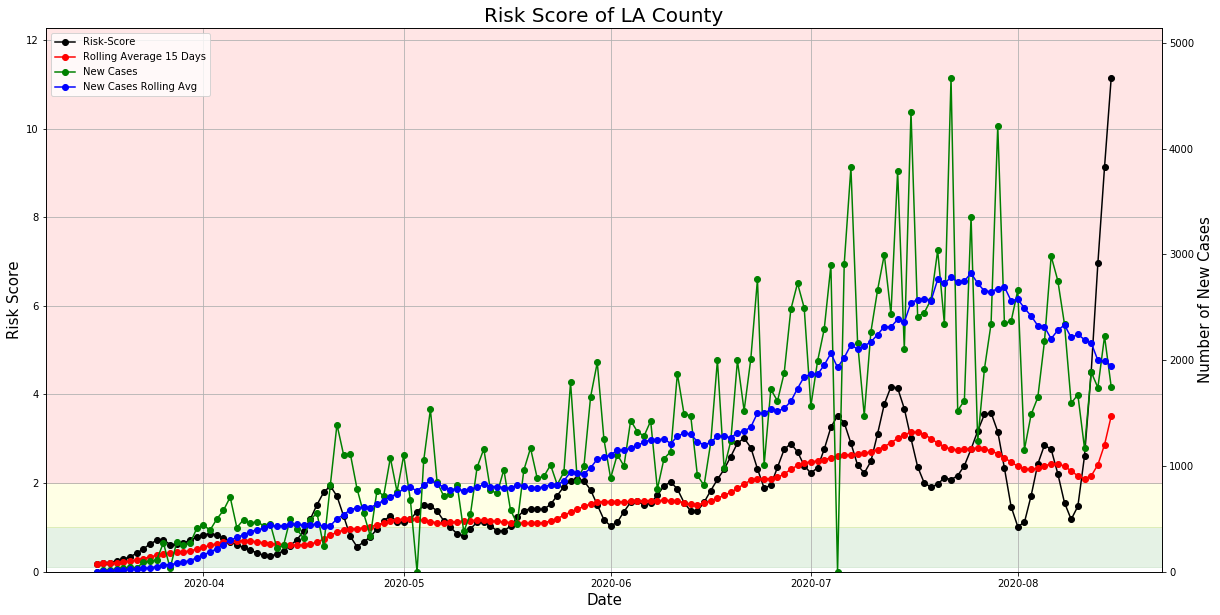

In [171]:
plot_rs('LA County',15, 13)

In [91]:
# In order to find out how Risk-Level was defined, I used code below:

score1=df[df['Risk-Level']==1]['Risk-Score']
score2=df[df['Risk-Level']==2]['Risk-Score']
score3=df[df['Risk-Level']==3]['Risk-Score']
print(max(score2))
print(min(score3))

# Looks like level 1 is given to risk score of 0~1, level 2 is given to risk score of 1~2, and level 3 to risk score greater than 2.

1.9997663368834293
2.000270302927293


In [92]:
# List of all the regions in the data

df['Region'].unique()

array(['Alhambra', 'Arcadia', 'Beverly Hills', 'Boyle Heights', 'Carson',
       'Diamond Bar', 'Encino', 'Gardena', 'Glendale', 'Glendora',
       'Granada Hills', 'Inglewood', 'La Mirada', 'Lancaster',
       'Manhattan Beach', 'Melrose', 'Northridge', 'San Dimas',
       'San Pedro', 'Santa Monica', 'Sherman Oaks', 'Silverlake',
       'Tarzana', 'Torrance', 'Venice', 'West Adams', 'West Hills',
       'West Hollywood', 'West Vernon', 'Westchester', 'Altadena',
       'Baldwin Hills', 'Brentwood', 'Culver City', 'Eagle Rock',
       'Hollywood', 'Hollywood Hills', 'Lynwood', 'Mar Vista',
       'Monterey Park', 'North Hollywood', 'Reseda', 'Woodland Hills',
       'Century Palms/Cove', 'Sylmar', 'Walnut', 'West Los Angeles',
       'Beverlywood', 'Burbank', 'Calabasas', 'Castaic', 'Covina',
       'Crestview', 'East Los Angeles', 'Echo Park', 'Hancock Park',
       'Hawthorne', 'Lawndale', 'Lomita', 'Pacific Palisades', 'Palms',
       'Playa Vista', 'Santa Monica Mountains', 'South

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


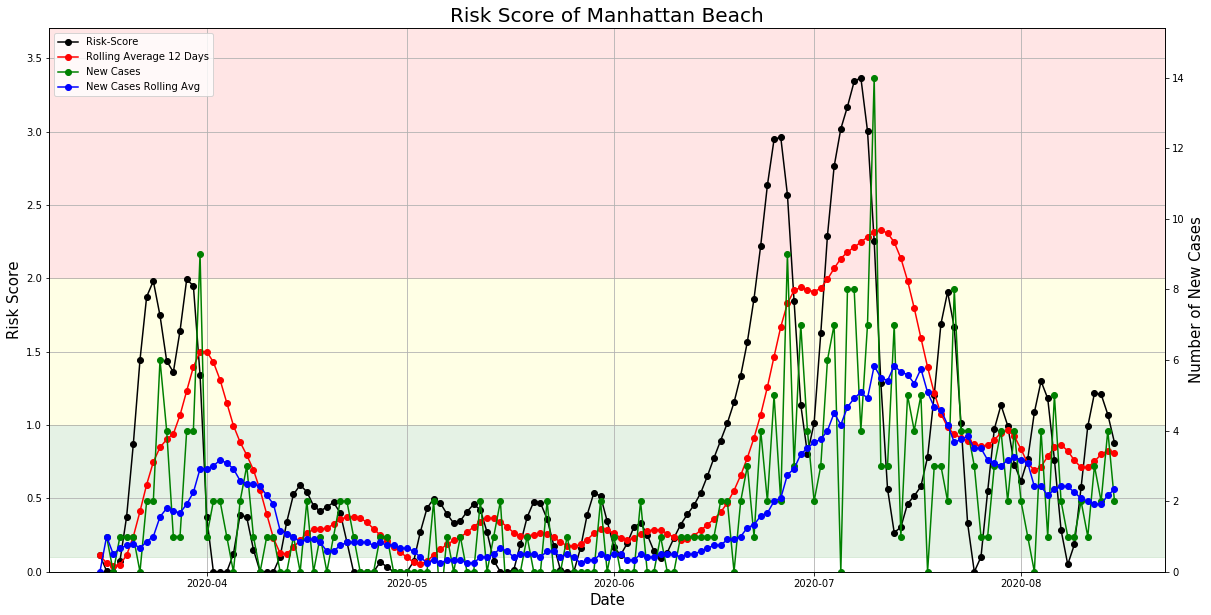

In [172]:
plot_rs('Manhattan Beach',12, 13)

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


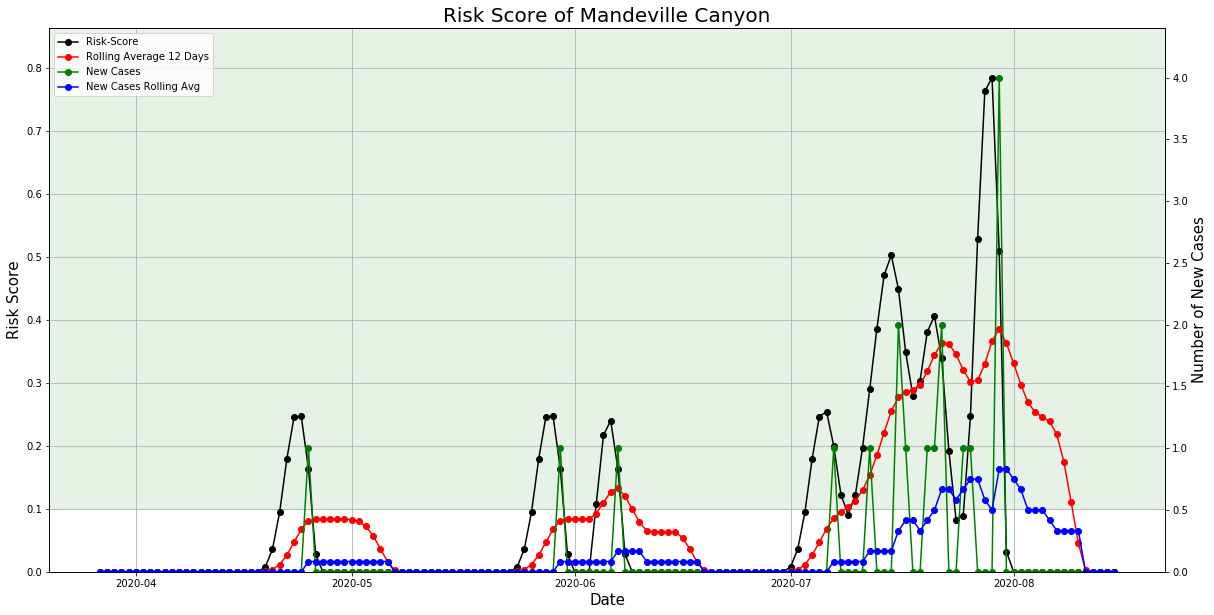

In [129]:
plot_rs('Mandeville Canyon',12, 14)

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


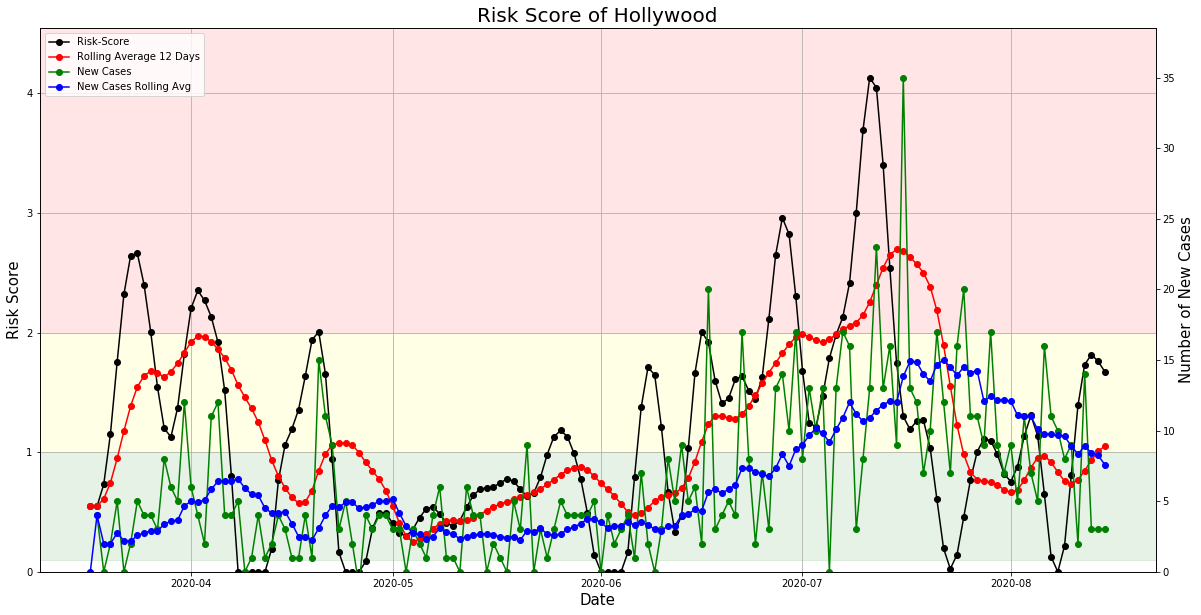

In [135]:
plot_rs('Hollywood',12, 14)

In [131]:
# This function calculates trend of the Risk-Score at the most current data.
# Input:  length1, length2:    these parameters define the windows Risk Score differences
#         rolling_length:      window of the rolling average calculation
#         rolling_diff_length: window used to calculate the rolling average difference
# Output: recent:             this new dataframe contains list of all regions with calculated Risk Score Trends on the most current data

def rs_trend_summary(length1,length2,rolling_length,rolling_diff_length):
    
    #intializing variables
    recent = pd.DataFrame()
    df_recent_1= pd.DataFrame()
    df_recent_2= pd.DataFrame()
    recent
    
    df_new=df.copy()
    regions = df_new['Region'].unique()
#     recent['Region']=regions
#     recent['Date']=recent['Region']
    
    
    for region in regions:
        df_region = df_new[df_new['Region']==region].sort_values('Time Stamp')
        
        recent_date = max(df_region['Time Stamp'])
#         recent.loc[recent['Region']=='Alhambra','Date'] = recent_date
        
        length1_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length1)
        length2_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length2)

        df_1_before = df_region[df_region['Time Stamp'] == length1_bef]
        df_2_before = df_region[df_region['Time Stamp'] == length2_bef]
        df_recent = df_region[df_region['Time Stamp']==recent_date]
        

        string1= "RS_change_{}_Days".format(length1)
        string2= "RS_change_{}_Days".format(length2)
        
        if not df_1_before['Risk-Score'].empty:
            df_recent[string1] = df_recent['Risk-Score'].iloc[0]-df_1_before['Risk-Score'].iloc[0]
        else:
            df_recent[string1] = df_recent['Risk-Score'].iloc[0]

        if not df_2_before['Risk-Score'].empty:
            df_recent[string2] = df_recent['Risk-Score'].iloc[0]-df_2_before['Risk-Score'].iloc[0]
        else:
            df_recent[string2] = df_recent['Risk-Score'].iloc[0]
        
        
        
        #Rolling Avreage
        rolling_rs = df_region['Risk-Score'].rolling(rolling_length, min_periods=1).mean()
        
        recent_rolling = rolling_rs.iloc[-1]
        length3 = 0 - rolling_diff_length -1
        past_rolling = rolling_rs.iloc[length3]
        
        rolling_diff = recent_rolling - past_rolling
        
            
        
        df_recent["Recent_Rolling_Average"] = recent_rolling
        df_recent["Past_Rolling_Average"] = past_rolling
        df_recent["Rolling_Difference"] = rolling_diff
        
        threshhold=1/7

        if rolling_diff > threshhold:
            df_recent['Risk_Trend_Abs'] = 'Red'
        if (rolling_diff < threshhold) & (rolling_diff > -threshhold):
            df_recent['Risk_Trend_Abs'] = 'Yellow'
        if rolling_diff < -threshhold:
            df_recent['Risk_Trend_Abs'] = 'Green'
        
        percent_change = (rolling_diff)*100/past_rolling
        percent_threshhold = 5
        df_recent['percent_change']=round(percent_change)
        
        if percent_change > percent_threshhold:
            df_recent['Risk_Trend_%'] = 'Red'
        if (percent_change < percent_threshhold) & (percent_change > -percent_threshhold):
            df_recent['Risk_Trend_%'] = 'Yellow'
        if percent_change < -percent_threshhold:
            df_recent['Risk_Trend_%'] = 'Green'
        
#         if rolling_diff > threshhold:
#             df_recent['Risk_Trend_Abs'] = 'Red'
#         if (rolling_diff < threshhold) & (rolling_diff > -threshhold):
#             df_recent['Risk_Trend_Abs'] = 'Yellow'
#         if rolling_diff < -threshhold:
#             df_recent['Risk_Trend_Abs'] = 'Grenn'
        
        
        recent = recent.append(df_recent).sort_values('Time Stamp')
#         recent=recent.drop(['index','Time Stamp','Latitude', 'Longitude','RS_change_3_Days','RS_change_14_Days'], axis=1)
        recent = recent[['Region','Rolling_Difference','Risk_Trend_Abs','percent_change','Risk_Trend_%']]
    return recent

In [132]:
a = rs_trend_summary(3,14,12,1)
a

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,Region,Rolling_Difference,Risk_Trend_Abs,percent_change,Risk_Trend_%
32697,Wilmington,0.087441,Yellow,1.0,Yellow
32689,West Whittier/Los Nietos,0.196111,Red,6.0,Red
32682,Wellington Square,-0.023798,Yellow,-5.0,Yellow
32678,Victoria Park,-0.002233,Yellow,-0.0,Yellow
32649,South Pasadena,0.045273,Yellow,14.0,Red
32600,Mt. Washington,-0.032422,Yellow,-4.0,Yellow
32564,Koreatown,0.184398,Red,6.0,Red
32558,Huntington Park,0.064786,Yellow,1.0,Yellow
32555,Historic Filipinotown,0.118914,Yellow,16.0,Red
32519,Downtown,0.068845,Yellow,4.0,Yellow


C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


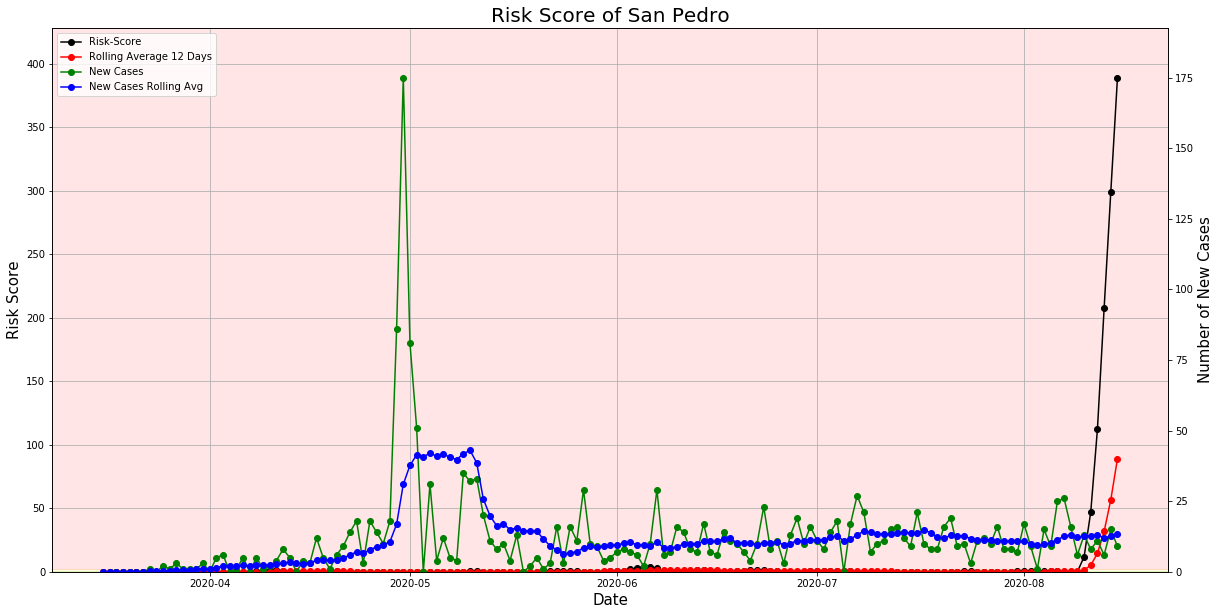

In [133]:
city='San Pedro'
plot_rs(city,12, 6)


In [134]:
calc_risk_trend(city, 12, 6)

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index_x,Time Stamp,Region,Latitude,Longitude,Risk-Score,Risk-Level,Number of cases,New Cases,index_y,RS_change_12,index,RS_change_6,Rolling Average 12 Days,Rolling Average 6 Days,New Cases Rolling Avg
18,18,2020-03-16,San Pedro,33.735852,-118.292293,0.000000,0,1,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000
58,58,2020-03-17,San Pedro,33.735852,-118.292293,0.000000,0,1,0.0,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000
99,100,2020-03-18,San Pedro,33.735852,-118.292293,0.000000,0,1,0.0,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000
157,159,2020-03-19,San Pedro,33.735852,-118.292293,0.000000,0,1,0.0,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000
235,239,2020-03-20,San Pedro,33.735852,-118.292293,0.000000,0,1,0.0,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000
319,325,2020-03-21,San Pedro,33.735852,-118.292293,0.000000,0,1,0.0,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000
416,425,2020-03-22,San Pedro,33.735852,-118.292293,0.000000,0,1,0.0,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000
521,533,2020-03-23,San Pedro,33.735852,-118.292293,0.000000,0,2,1.0,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.142857
639,654,2020-03-24,San Pedro,33.735852,-118.292293,0.000000,0,2,0.0,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.125000
763,781,2020-03-25,San Pedro,33.735852,-118.292293,0.000000,0,4,2.0,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.333333
